# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Project Goal

Explore the Starbucks data to understand how people shopping in Starbucks with promotional offers. 
Questions to answer some questions:
1)what is the distribution that customer in numbers related to age and income
2)build a machine learning model to predict if a customer will complete an offer or not
3)suggestions on demographic groups that will make purchases even if they don't receive an offer
 

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#import all the libraries will be used in this project
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Quick look at the tables**

In [2]:
#check the size of the table
portfolio.shape

(10, 6)

In [3]:
#since the table size is small, print the whole table and table a look at the table
portfolio.sort_values(by='offer_type')

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


In [4]:
#check general information, also check missing data information from the output
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.sample(5)

,event,person,time,value
246247,offer received,cc44cc35b0f044aaa9f174549fe86577,576,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
222511,offer viewed,436c610d0637412f8cc101b6e5b4b52a,516,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
161813,offer received,8d7c5413f98d405e88fd4f35cb705780,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
288802,offer completed,f66a9335025741b3b18a961dfdb2f28e,642,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
287016,transaction,29fdfc06b7ea4373907b1f26389a675a,636,{'amount': 8.9}


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


From the quick check on the tables, we can see that there are 10 rows and 6 columns in table portfolio with no missing values; there are 306,434 rows and 4 columns in table transcript with no missing values; there are 17,000 rows and 5 columns in profile table and there are missing values in columns "gender" and "income"

**Explore and Clean the datasets**

In [9]:
#list the unique type of offer types
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [10]:
#double check that each offer is unique with unique offer id
portfolio.groupby(["id", "offer_type"]).count()["reward"].reset_index()

,id,offer_type,reward
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1
2,2906b810c7d4411798c6938adc9daaa5,discount,1
3,3f207df678b143eea3cee63160fa8bed,informational,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1
5,5a8bc65990b245e5a138643cd4eb9837,informational,1
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1
9,fafdcd668e3743c1bb461111dcafc2a4,discount,1


In [11]:
#create dummy columns email, mobile, social and web and assign boolean values based on channels column
col_names=["email", "mobile", "social", "web"]
for col in col_names:
    portfolio[col]=portfolio["channels"].apply(lambda x: 1 if col in x else 0)    

In [12]:
#convert the duration from days to hours, rename id to offer_id and drop the duration column
# portfolio["new_offer_id"]=range(1,11)
portfolio["duration_h"]=portfolio["duration"]*24
portfolio.drop(["duration", "channels"], axis=1, inplace=True)
portfolio.rename(columns={"id":"offer_id"}, inplace=True)
portfolio.head()

,difficulty,offer_id,offer_type,reward,email,mobile,social,web,duration_h
0,10,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,168
1,10,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120
2,0,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,96
3,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,168
4,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,240


In [13]:
profile.id.nunique()

17000

In [14]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile.groupby(["gender"])["income"].size()

gender
F    6129
M    8484
O     212
Name: income, dtype: int64

In [16]:
#rename id column to customer_id, create simplier customer id column
# profile["new_cid"]=range(1,17001)
profile.rename(columns={"id":"customer_id"}, inplace=True)
#create member days column from became member on day column
profile['m_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['m_days'] = profile['m_days'].dt.days
profile.head()

,age,became_member_on,gender,customer_id,income,m_days
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1799
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1646
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1284
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1713
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,1626


In [17]:
#check the income value when age=118, turns out all income is nan when age=118 and no gender
profile[profile.age==118].income.isna().sum()

2175

In [18]:
#create a subset for profile table which drop all the rows when income is nan
profile_sub=profile.dropna(subset=["income"])

In [19]:
profile_sub.describe()

,age,became_member_on,income,m_days
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1792.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,1270.000000
25%,42.000000,2.016052e+07,49000.000000,1478.000000
50%,55.000000,2.017080e+07,64000.000000,1628.000000
75%,66.000000,2.017123e+07,80000.000000,2067.000000
max,101.000000,2.018073e+07,120000.000000,3093.000000


### What is the age distribution between the group has an income lower than the mean income and the one that equal and greater than mean income? ###

In [20]:
#create a subset which has an income lower than the mean value of income in the profile table
mask_income=profile_sub.income/1000<64

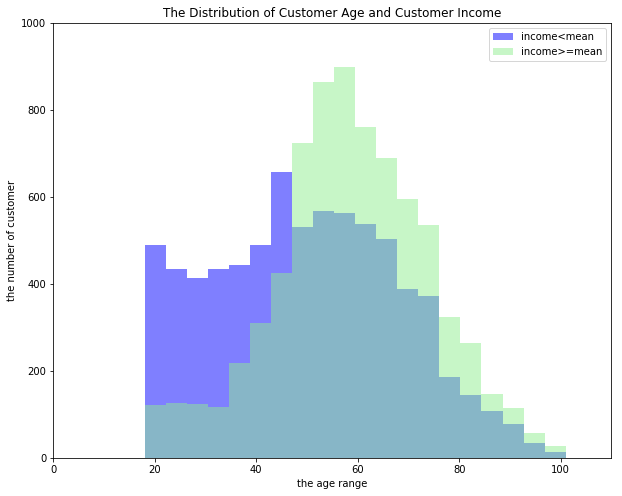

In [21]:
#plot the hists of age with income groups in terms of the number of customers
profile_sub.age[mask_income].plot(kind='hist',alpha=0.5,bins=20,color='blue',label='income<mean',figsize=(10,8))
profile_sub.age[~mask_income].plot(kind='hist',alpha=0.5,bins=20,color='lightgreen',label='income>=mean',figsize=(10,8))
plt.axis([0,110,0,1000])
plt.xlabel('the age range')
plt.ylabel('the number of customer')
plt.title('The Distribution of Customer Age and Customer Income')
plt.legend();

In [22]:
profile_sub.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [23]:
profile_sub.gender.value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

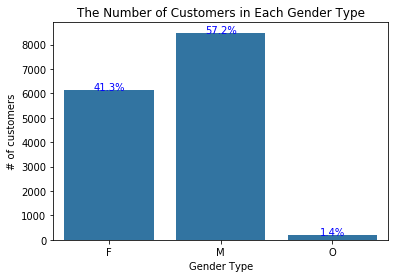

In [24]:
#use seaborn to plot the count of each gender recorded in the profile data
base_color=sn.color_palette()[0]
#drop the rows with empty value for gender
# profile_bar=profile.dropna(subset=['gender'])
sn.countplot(data=profile_sub, x="gender", color=base_color)

# add annotations
n_points = profile_sub.shape[0]
cat_counts = profile_sub['gender'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'B')

plt.xlabel('Gender Type')
plt.ylabel('# of customers')
plt.title('The Number of Customers in Each Gender Type')
plt.legend();

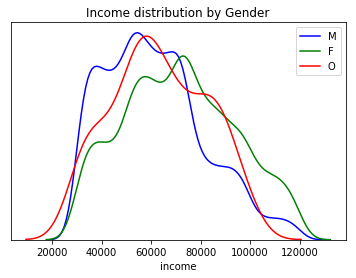

In [25]:
# the income distribution in each gender group.
sn.distplot(profile_sub[profile_sub['gender']=='M']['income'],hist=False,color="b",kde_kws={"shade": False},label="M");
sn.distplot(profile_sub[profile_sub['gender']=='F']['income'],hist=False,color="g",kde_kws={"shade": False},label="F");
sn.distplot(profile_sub[profile_sub['gender']=='O']['income'],hist=False,color="r",kde_kws={"shade": False},label="O");
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend()
plt.show();

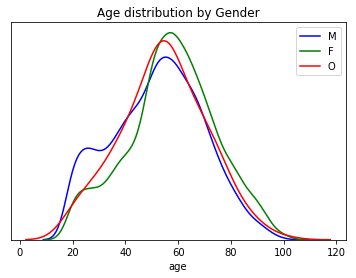

In [26]:
# the income distribution in each gender group.
sn.distplot(profile_sub[profile_sub['gender']=='M']['age'],hist=False,color="b",kde_kws={"shade": False},label="M");
sn.distplot(profile_sub[profile_sub['gender']=='F']['age'],hist=False,color="g",kde_kws={"shade": False},label="F");
sn.distplot(profile_sub[profile_sub['gender']=='O']['age'],hist=False,color="r",kde_kws={"shade": False},label="O");
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend()
plt.show();

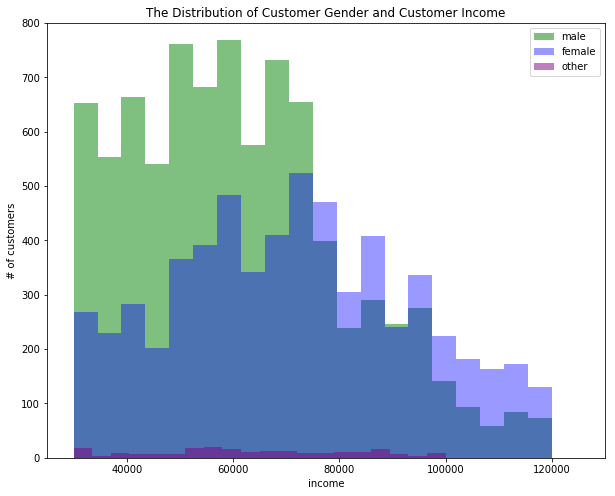

In [27]:
#plot the stack histgram of income in each gender group
mask_f=profile_sub.gender=="F"
mask_m=profile_sub.gender=="M"
mask_o=profile_sub.gender=="O"
profile_sub.income[mask_m].plot(kind="hist", alpha=0.5, bins=20, color="green", label="male", figsize=(10, 8))
profile_sub.income[mask_f].plot(kind="hist", alpha=0.4, bins=20, color="blue", label="female", figsize=(10, 8))
profile_sub.income[mask_o].plot(kind="hist", alpha=0.5, bins=20, color="purple", label="other", figsize=(10, 8))
plt.axis([25000, 130000, 0,800])
plt.xlabel("income")
plt.ylabel("# of customers")
plt.title("The Distribution of Customer Gender and Customer Income")
plt.legend()

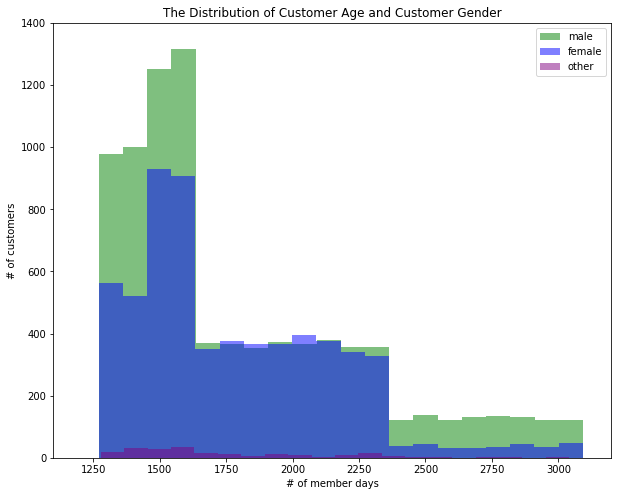

In [28]:
mask_f=profile_sub.gender=="F"
mask_m=profile_sub.gender=="M"
mask_o=profile_sub.gender=="O"
profile_sub.m_days[mask_m].plot(kind="hist", alpha=0.5, bins=20, color="green", label="male", figsize=(10, 8))
profile_sub.m_days[mask_f].plot(kind="hist", alpha=0.5, bins=20, color="blue", label="female", figsize=(10, 8))
profile_sub.m_days[mask_o].plot(kind="hist", alpha=0.5, bins=20, color="purple", label="other", figsize=(10, 8))
plt.axis([1100,3200, 0, 1400])
plt.xlabel("# of member days")
plt.ylabel("# of customers")
plt.title("The Distribution of Customer Age and Customer Gender")
plt.legend()

In [29]:
# check if the transcript table has any missing value
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [30]:
#print out the unique transcript types
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [31]:
# checking the count of each event type
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [32]:
# rename columns name for transcript table
transcript.rename(columns={"time":"start_h", "person":"customer_id"}, inplace=True)

In [33]:
#get all the keys from the value column which is formatted as dictionary
keys = []
for idx, row in transcript.iterrows():
    for i in row['value']:
        if i in keys:
            continue
        else:
            keys.append(i)
keys            

['offer id', 'amount', 'offer_id', 'reward']

In [34]:
#create columns and specify the datatype of each of them
transcript['offer_id'] = '' # datatype : string
transcript['amount'] = 0  # datatype : integer
transcript['reward'] = 0  # datatype : integer

#iterate each row to check and update the value of the offer_id, amount and reward columns with the value from the dic
for idx, row in transcript.iterrows():
    for i in row['value']:
        if i in("offer_id", "offer id"):
            transcript.at[idx, 'offer_id'] = row['value'][i]
        if i == 'amount':
            transcript.at[idx, 'amount'] = row['value'][i]
        if i == 'reward':
            transcript.at[idx, 'reward'] = row['value'][i]

#filling the blanks in the offer_id column with N/As
transcript["offer_id"]=transcript["offer_id"].apply(lambda x: "N/A" if x=="" else x)
#drop the value column from the table
transcript.drop("value", axis=1, inplace=True)

In [35]:
#sampling 10 rows of the data to check the result
transcript.sample(10)

,event,customer_id,start_h,offer_id,amount,reward
265445,transaction,9b84c5f2038e4f638813091d3565a8f0,582,N/A,0,0
280924,offer completed,00bc42a62f884b41a13cc595856cf7c3,618,fafdcd668e3743c1bb461111dcafc2a4,0,2
243021,offer completed,90b9b612883340d683fdc1979dd79831,564,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10
140290,transaction,8dbfa485249f409aa223a2130f40634a,372,N/A,2,0
263490,offer viewed,6368c154e8014fa49bc178a60f453b04,582,2906b810c7d4411798c6938adc9daaa5,0,0
17946,transaction,a762f4e5106948429941aeceae74a968,6,N/A,3,0
28328,transaction,641eff6a55404458899c9ed37ca9f4b9,42,N/A,15,0
98197,transaction,4e3fa85725f141f6b4bf3bae3a485986,264,N/A,5,0
236544,transaction,f3ab5d3926434b5c931f78eb07aa7787,546,N/A,15,0
203281,offer received,9299c46942f84bb6b5e98fd78fbb9d41,504,ae264e3637204a6fb9bb56bc8210ddfd,0,0


In [36]:
trans_bar=transcript.groupby(["event"]).count().sort_values(by=["customer_id"], ascending=False).reset_index()
trans_bar

,event,customer_id,start_h,offer_id,amount,reward
0,transaction,138953,138953,138953,138953,138953
1,offer received,76277,76277,76277,76277,76277
2,offer viewed,57725,57725,57725,57725,57725
3,offer completed,33579,33579,33579,33579,33579


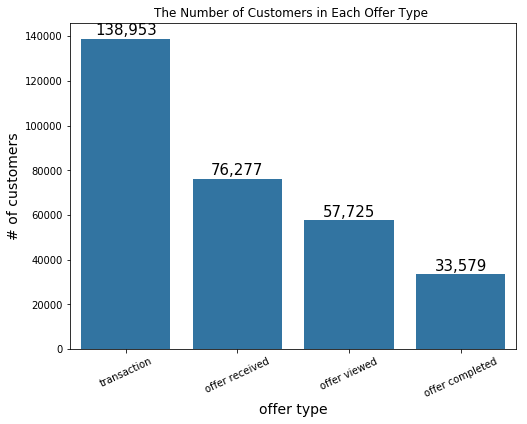

In [37]:
# Defining the plot size
plt.figure(figsize=(8, 6))
# Defining the color of the bars
base_color=sn.color_palette()[0]

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sn.barplot(x="event", y="customer_id", data=trans_bar, color=base_color)

# Iterrating over the bars one-by-one
for bar in plots.patches:

# Using Matplotlib's annotate function and
# passing the coordinates where the annotation shall be done
# x-coordinate: bar.get_x() + bar.get_width() / 2
# y-coordinate: bar.get_height()
# free space to be left to make graph pleasing: (0, 8)
# ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), ',.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

# Setting the label for x-axis
plt.xlabel("offer type", size=14)
plt.xticks(rotation = 25)

# Setting the label for y-axis
plt.ylabel("# of customers", size=14)

# Setting the title for the graph
plt.title("The Number of Customers in Each Offer Type ")

# Finally showing the plot
plt.show()


In [38]:
transcript.customer_id.duplicated().sum()

289534

In [39]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event          306534 non-null object
customer_id    306534 non-null object
start_h        306534 non-null int64
offer_id       306534 non-null object
amount         306534 non-null int64
reward         306534 non-null int64
dtypes: int64(3), object(3)
memory usage: 14.0+ MB


In [40]:
trans=transcript["event"]=="transaction"
trans_cus=transcript[trans]
offer_cus=transcript[~trans]

In [41]:
trans_cus.shape, offer_cus.shape

((138953, 6), (167581, 6))

In [42]:
common_cus=pd.merge(trans_cus[["customer_id", "event"]],offer_cus, how="inner", on=["customer_id"])

In [43]:
common_cus.head()

,customer_id,event_x,event_y,start_h,offer_id,amount,reward
0,02c083884c7d45b39cc68e1314fec56c,transaction,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
1,02c083884c7d45b39cc68e1314fec56c,transaction,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
2,02c083884c7d45b39cc68e1314fec56c,transaction,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
3,02c083884c7d45b39cc68e1314fec56c,transaction,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
4,02c083884c7d45b39cc68e1314fec56c,transaction,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0


In [44]:
common_cus.shape

(1465827, 7)

In [45]:
common_cus.customer_id.nunique()

16572

In [46]:
# find the number customers completed offers and made transaction
complete_n_trans_id=common_cus[common_cus.event_y=="offer completed"].customer_id
complete_n_trans=complete_n_trans_id.nunique()
complete_n_trans

12774

In [47]:
# find the number customers did not completed offers and made transaction
incomplete_n_trans_id=common_cus[~common_cus.customer_id.isin(complete_n_trans_id)].customer_id
incomplete_n_trans=incomplete_n_trans_id.nunique()
incomplete_n_trans

3798

In [48]:
# create the table that exclude data in the common customer table 
trans_and_offer=common_cus.customer_id.unique() # find the customer id that made transaction and recieved offers
customer_no_offer=transcript.query("customer_id not in @trans_and_offer")
# customer_no_offer_id=customer_no_offer.customer_id

In [49]:
# find the number customers did not receive any offers but made transaction
noffer_n_trans_id=customer_no_offer[customer_no_offer.event=="transaction"].customer_id
noffer_n_trans=noffer_n_trans_id.nunique()
noffer_n_trans

6

In [58]:
# find the number customers did not completed offers and did not made transaction
incomplete_no_trans_id=customer_no_offer[customer_no_offer.event != "transaction"].customer_id
incomplete_no_trans=incomplete_no_trans_id.nunique()
incomplete_no_trans

422

In [51]:
#check when customer made no transaction, if they receive any offers
incomplete_no_trans=customer_no_offer[customer_no_offer.event != "transaction"]
incomplete_no_trans.event.unique()

array(['offer received', 'offer viewed'], dtype=object)

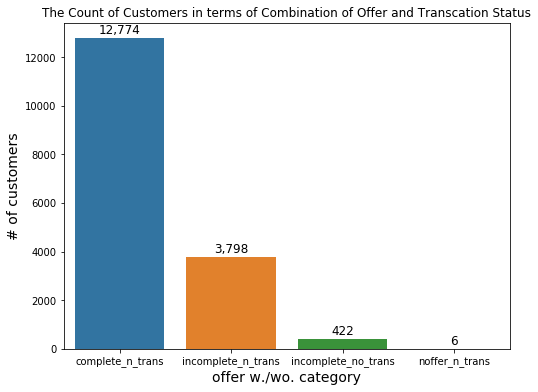

In [60]:
# plot the detailed numbers of the customers regarding the response to offers and making transcations
# put the 4 numbers into a data frame
data={"category":["complete_n_trans","incomplete_n_trans", "incomplete_no_trans", "noffer_n_trans"],
      "numbers":[complete_n_trans, incomplete_n_trans, incomplete_no_trans, noffer_n_trans]}
count_compare = pd.DataFrame(data, columns=['category', 'numbers'])
# set the size of the plot and use seaborn for the plotting
plt.figure(figsize=(8, 6))
plots = sn.barplot(x="category", y="numbers", data=count_compare) 
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), ',.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.title("The Count of Customers in terms of Combination of Offer and Transcation Status")
# Setting the x-acis label and its size
plt.xlabel("offer w./wo. category", size=14)
# Setting the y-axis label and its size
plt.ylabel("# of customers", size=14)
# Plotting the graph
plt.show()

### Create a master table by merge all three tables together

In [61]:
#merge all the tables by left join on keys offer_id and customer_id
df_trans_port=transcript.merge(portfolio, how="left", on="offer_id")
df_combine=df_trans_port.merge(profile, how="left", on="customer_id")
df_combine.drop(["became_member_on"], axis=1, inplace=True)
df_combine.rename(columns={"reward_x":"reward_received", "reward_y":"reward_expected"}, inplace=True)

In [63]:
# rearrange the column positions

df_combine=df_combine[['customer_id','offer_id', 'event', 'gender','age', 'income', 'offer_type','difficulty',
                       'm_days','start_h','duration_h','reward_expected','reward_received',
                       'amount','email', 'mobile', 'social', 'web']]
print("The shape of the master table is :", df_combine.shape)
print("\n")
df_combine.head()

(306534, 18)




,customer_id,offer_id,event,gender,age,income,offer_type,difficulty,m_days,start_h,duration_h,reward_expected,reward_received,amount,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,F,75,100000.0,bogo,5.0,1713,0,168.0,5.0,0,0,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,None,118,NaN,discount,20.0,1626,0,240.0,5.0,0,0,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,M,68,70000.0,discount,10.0,1361,0,168.0,2.0,0,0,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer received,None,118,NaN,discount,10.0,1574,0,240.0,2.0,0,0,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,None,118,NaN,bogo,10.0,1567,0,120.0,10.0,0,0,1.0,1.0,1.0,1.0


In [64]:
df_combine.describe()

,age,income,difficulty,m_days,start_h,duration_h,reward_expected,reward_received,amount,email,mobile,social,web
count,306534.000000,272762.000000,167581.000000,306534.000000,306534.000000,167581.000000,167581.00000,306534.000000,306534.000000,167581.0,167581.000000,167581.000000,167581.000000
mean,60.909367,64337.000755,7.850401,1844.943011,366.382940,158.657700,4.41991,0.537219,5.570133,1.0,0.917944,0.656996,0.806858
std,26.032030,21243.762941,5.048944,421.482784,200.326314,51.267123,3.37336,1.805208,21.266669,0.0,0.274451,0.474714,0.394765
min,18.000000,30000.000000,0.000000,1270.000000,0.000000,72.000000,0.00000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,43.000000,48000.000000,5.000000,1512.000000,186.000000,120.000000,2.00000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,57.000000,62000.000000,10.000000,1739.000000,408.000000,168.000000,5.00000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,72.000000,78000.000000,10.000000,2126.000000,528.000000,168.000000,5.00000,0.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,118.000000,120000.000000,20.000000,3093.000000,714.000000,240.000000,10.00000,10.000000,1062.000000,1.0,1.000000,1.000000,1.000000


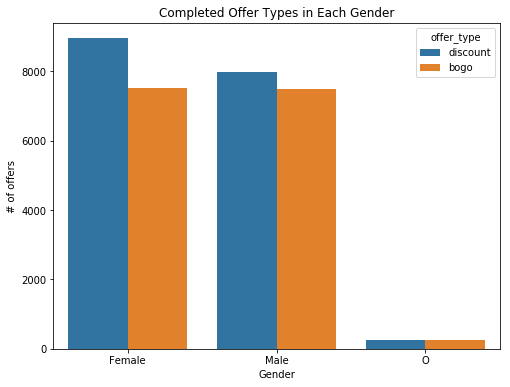

In [65]:
#plot the count of completed offer in each group
df_g=df_combine.query('customer_id in @complete_n_trans_id and event=="offer completed"')
plt.figure(figsize=(8, 6))
g = sn.countplot(x="gender", hue="offer_type", data= df_g)
plt.title('Completed Offer Types in Each Gender')
plt.ylabel('# of offers')
xlabels = ["Female", "Male", "O"]
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.show();

### Data Modeling 

In [103]:
df_combine.isnull().sum()

customer_id             0
offer_id                0
event                   0
gender              33772
age                     0
income              33772
offer_type         138953
difficulty         138953
m_days                  0
start_h                 0
duration_h         138953
reward_expected    138953
reward_received         0
amount                  0
email              138953
mobile             138953
social             138953
web                138953
dtype: int64

In [ ]:
df_m["gender"].fillna("O")

In [66]:
df_m=df_combine.query('customer_id not in @noffer_n_trans_id and (event=="offer received" or event=="offer completed")')


(109856, 18)

In [67]:
df_m.event.unique()

array(['offer received', 'offer completed'], dtype=object)

In [68]:
df_m=df_m.dropna(axis=0)
df_m.shape

(98945, 18)

In [88]:
df= pd.get_dummies(df_m, columns=["offer_type", "gender", "event"])
df.drop(["customer_id", "offer_id","start_h", "reward_received",\
         "offer_type_informational","event_offer received"], axis=1, inplace=True)
df.head()

In [92]:
df.rename(columns={"offer_type_bogo":"bogo", 
                   "offer_type_discount":"discount",
                   "gender_F":"F", 
                   "gender_M":"M", 
                   "gender_O":"O", 
                   "event_offer completed":"event"}, inplace=True)
df.head()

,age,income,difficulty,m_days,duration_h,reward_expected,amount,email,mobile,social,web,bogo,discount,F,M,O,event
0,75,100000.0,5.0,1713,168.0,5.0,0,1.0,1.0,0.0,1.0,1,0,1,0,0,0
2,68,70000.0,10.0,1361,168.0,2.0,0,1.0,1.0,0.0,1.0,0,1,0,1,0,0
5,65,53000.0,5.0,1437,120.0,5.0,0,1.0,1.0,1.0,1.0,1,0,0,1,0,0
7,58,51000.0,0.0,1527,96.0,0.0,0,1.0,1.0,0.0,1.0,0,0,0,1,0,0
8,61,57000.0,20.0,1588,240.0,5.0,0,1.0,0.0,0.0,1.0,0,1,1,0,0,0


In [93]:
Feature=df[["age", "income", "difficulty", "m_days", "duration_h", "reward_expected",
            "amount", "email", "mobile", "social","web", "bogo", "discount", "F", "M", "O"]]

In [94]:
X=Feature
y=df["event"]

### Data Processing

In [95]:

X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (79156, 16) (79156,)
Test set: (19789, 16) (19789,)


### Logistic Regression

In [96]:
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
yhat = LR_model.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

### Decision Tree

In [98]:
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
print(DT_model)
yhat = DT_model.predict(X_test)
print(yhat)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
[0 0 0 ..., 0 0 0]


Model Evaluation 

In [99]:
DT_yhat = DT_model.predict(X_test)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(y_test, DT_yhat))
print("DT F1-score: %.2f" % f1_score(y_test, DT_yhat, average='weighted') )

DT Jaccard index: 0.67
DT F1-score: 0.54


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("LR F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

LR Jaccard index: 0.67
LR F1-score: 0.58
LR LogLoss: 0.56


### Conclusion